사용 디바이스: cuda
향상된 데이터셋 로딩 중...
훈련 데이터셋: 8000개
데이터 정규화 적용됨
테스트 데이터셋: 2000개
데이터 정규화 적용됨
향상된 모델 생성 - 파라미터 수: 3,480,458
고급 훈련 시작 - Epochs: 150, LR: 0.002, Device: cuda
Epoch  Train Loss   Test Loss    Best Test    LR        
------------------------------------------------------------
0      2.215241     0.845886     0.845886     0.001989  
10     0.886547     0.678899     0.678899     0.000959  
20     0.884690     0.670077     0.622164     0.001997  
30     0.824732     0.617357     0.609665     0.001685  
40     0.780197     0.571901     0.571901     0.001029  
50     0.746047     0.541054     0.541054     0.000416  
60     0.798199     0.586248     0.524873     0.001999  
70     0.771895     0.549959     0.524873     0.001917  
80     0.729215     0.519380     0.517014     0.001711  
90     0.693796     0.480475     0.474264     0.001412  
100    0.660818     0.468054     0.468054     0.001065  
110    0.636081     0.459185     0.452794     0.000723  
120    0.614956     0.437395     0

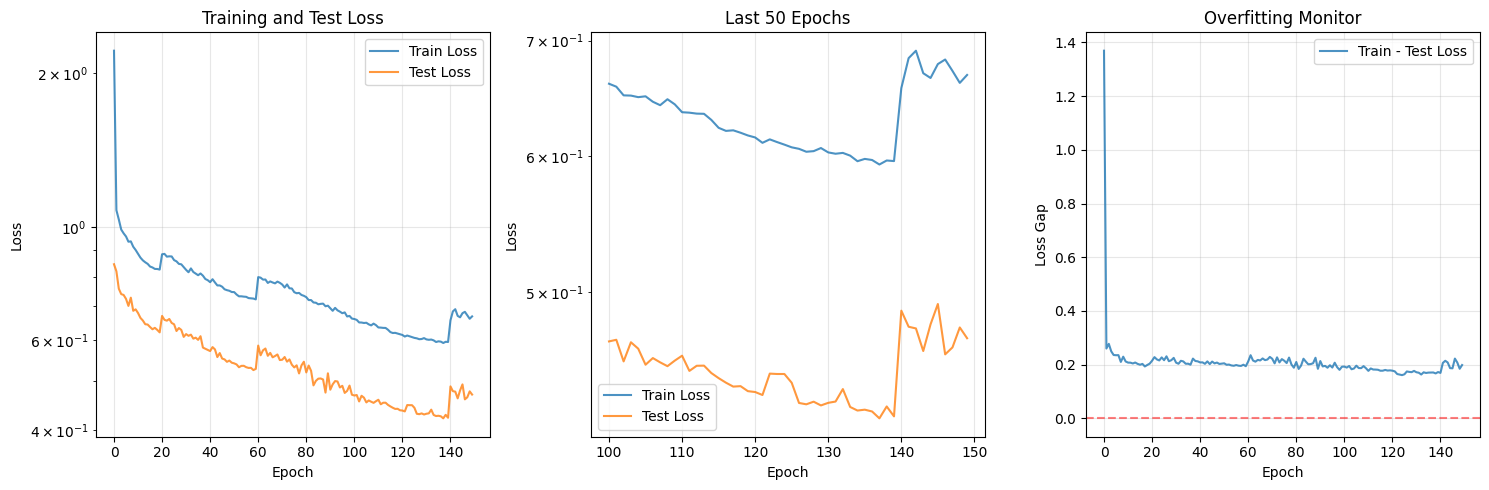


=== 향상된 모델 테스트 결과 ===

테스트 1:
방정식: 96.240x^5 + -85.064x^4 + -35.283x^3 + -2.883x^2 + 87.959x + -26.818 = 0
근별 비교:
  근 1:
    실제: 0.000000 + 0.330089i (크기: 0.330089)
    예측: -0.128108 + 0.434010i (크기: 0.452522)
    크기 오차: 0.122433
  근 2:
    실제: -0.639122 + -0.647935i (크기: 0.910108)
    예측: 0.021668 + -0.751747i (크기: 0.752059)
    크기 오차: 0.158049
  근 3:
    실제: 0.639122 + -0.647935i (크기: 0.910108)
    예측: 0.392082 + -0.717807i (크기: 0.817909)
    크기 오차: 0.092200
  근 4:
    실제: -0.404847 + 0.924824i (크기: 1.009555)
    예측: -0.157836 + 1.006430i (크기: 1.018731)
    크기 오차: 0.009176
  근 5:
    실제: 0.404847 + 0.924824i (크기: 1.009555)
    예측: 0.692866 + 3.201060i (크기: 3.275187)
    크기 오차: 2.265632
MSE 오차: 0.587242
평균 크기 오차: 0.529498

테스트 2:
방정식: 40.370x^5 + -47.924x^4 + -90.643x^3 + 83.653x^2 + -96.716x + -18.145 = 0
근별 비교:
  근 1:
    실제: 0.000000 + -0.161493i (크기: 0.161493)
    예측: -0.180509 + -0.225574i (크기: 0.288907)
    크기 오차: 0.127414
  근 2:
    실제: -0.813692 + 0.427487i (크기: 0.919152)
   

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

class PolynomialDataset(Dataset):
    def __init__(self, data_file, train=True, train_ratio=0.8, normalize=True):
        """
        저장된 데이터 파일로부터 Dataset 생성
        
        Args:
            data_file: 데이터 파일 경로 (.json 또는 .pkl)
            train: True면 훈련용, False면 테스트용
            train_ratio: 훈련/테스트 분할 비율
            normalize: 데이터 정규화 여부
        """
        self.data = self.load_data(data_file)
        self.normalize = normalize
        self.coeffs, self.roots = self.prepare_data()
        
        # 정규화 파라미터 저장
        if normalize:
            self.coeff_mean = np.mean(self.coeffs, axis=0)
            self.coeff_std = np.std(self.coeffs, axis=0) + 1e-8
            self.root_mean = np.mean(self.roots, axis=0)
            self.root_std = np.std(self.roots, axis=0) + 1e-8
            
            # 정규화 적용
            self.coeffs = (self.coeffs - self.coeff_mean) / self.coeff_std
            self.roots = (self.roots - self.root_mean) / self.root_std
        
        # 훈련/테스트 분할
        train_coeffs, test_coeffs, train_roots, test_roots = train_test_split(
            self.coeffs, self.roots, train_size=train_ratio, random_state=42
        )
        
        if train:
            self.coeffs = train_coeffs
            self.roots = train_roots
        else:
            self.coeffs = test_coeffs
            self.roots = test_roots
        
        print(f"{'훈련' if train else '테스트'} 데이터셋: {len(self.coeffs)}개")
        if normalize:
            print(f"데이터 정규화 적용됨")
    

    def load_data(self, filename):
        """데이터 파일 로드"""
        if filename.endswith('.json'):
            with open(filename, 'r', encoding='utf-8') as f:
                return json.load(f)
        elif filename.endswith('.pkl'):
            with open(filename, 'rb') as f:
                return pickle.load(f)
        else:
            raise ValueError("지원하지 않는 파일 형식입니다. (.json 또는 .pkl 사용)")
    
    def prepare_data(self):
        """데이터를 학습용 형태로 변환"""
        coeffs = []
        roots = []
        
        for item in self.data:
            coeffs.append(item['coefficients'])
            
            # 근 데이터 형식 확인 및 변환
            item_roots = item['roots']
            
            if isinstance(item_roots[0], list):
                # [[실수부, 허수부], ...] 형태를 [실수부1, 허수부1, ...] 형태로 평탄화
                flattened_roots = []
                for root in item_roots:
                    flattened_roots.extend(root)
                roots.append(flattened_roots)
            else:
                # 이미 [실수부1, 허수부1, ...] 형태
                roots.append(item_roots)
        
        return np.array(coeffs, dtype=np.float32), np.array(roots, dtype=np.float32)
    
    def denormalize_roots(self, normalized_roots):
        """근을 원래 스케일로 되돌리기"""
        if self.normalize and hasattr(self, 'root_mean'):
            return normalized_roots * self.root_std + self.root_mean
        return normalized_roots
    
    def __len__(self):
        return len(self.coeffs)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.coeffs[idx]), torch.FloatTensor(self.roots[idx])

class ResidualBlock(nn.Module):
    """잔차 연결 블록"""
    def __init__(self, size, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(size, size)
        self.linear2 = nn.Linear(size, size)
        self.norm1 = nn.LayerNorm(size)
        self.norm2 = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = torch.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.norm2(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x + residual

class AdvancedPolynomialRootNet(nn.Module):
    def __init__(self, input_size=6, output_size=10, hidden_size=1024, 
                 num_layers=8, dropout=0.2, use_residual=True):
        super(AdvancedPolynomialRootNet, self).__init__()
        
        self.use_residual = use_residual
        
        # 입력 층
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 중간 층들
        self.hidden_layers = nn.ModuleList()
        current_size = hidden_size
        
        for i in range(num_layers - 2):
            if use_residual and i % 2 == 0:  # 잔차 블록 사용
                self.hidden_layers.append(ResidualBlock(current_size, dropout))
            else:  # 일반 선형 층
                next_size = max(current_size // 2, 128)
                self.hidden_layers.append(nn.Sequential(
                    nn.Linear(current_size, next_size),
                    nn.LayerNorm(next_size),
                    nn.ReLU(),
                    nn.Dropout(dropout * 0.8)
                ))
                current_size = next_size
        
        # 출력 층 (여러 헤드)
        self.real_head = nn.Sequential(
            nn.Linear(current_size, current_size // 2),
            nn.ReLU(),
            nn.Linear(current_size // 2, 5)  # 5개 실수부
        )
        
        self.imag_head = nn.Sequential(
            nn.Linear(current_size, current_size // 2),
            nn.ReLU(),
            nn.Linear(current_size // 2, 5)  # 5개 허수부
        )
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        x = self.input_layer(x)
        
        for layer in self.hidden_layers:
            if isinstance(layer, ResidualBlock):
                x = layer(x)
            else:
                x = layer(x)
        
        # 실수부와 허수부 분리 예측
        real_parts = self.real_head(x)
        imag_parts = self.imag_head(x)
        
        # 인터리빙하여 [실수1, 허수1, 실수2, 허수2, ...] 형태로 만들기
        output = torch.zeros(x.size(0), 10, device=x.device)
        output[:, 0::2] = real_parts  # 짝수 인덱스에 실수부
        output[:, 1::2] = imag_parts  # 홀수 인덱스에 허수부
        
        return output

class AdvancedPolynomialTrainer:
    def __init__(self, model, train_loader, test_loader, device='cpu'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        
        # 훈련 기록
        self.train_losses = []
        self.test_losses = []
        self.best_test_loss = float('inf')
        self.best_model_state = None
    
    def polynomial_verification_loss(self, pred_roots, coeffs, weight=0.1):
        """
        예측된 근이 실제로 방정식을 만족하는지 확인하는 손실
        """
        batch_size = pred_roots.shape[0]
        verification_loss = torch.tensor(0.0, device=pred_roots.device)
        
        for i in range(batch_size):
            roots = pred_roots[i].view(5, 2)  # [실수부, 허수부] 쌍으로 재구성
            coeff = coeffs[i]
            
            # 각 근에 대해 다항식 값 계산 (간단 버전)
            for j in range(5):
                r, c = roots[j, 0], roots[j, 1]  # 실수부, 허수부
                # P(z) = a5*z^5 + a4*z^4 + ... + a0 계산 (실수부만 간단히)
                poly_val = (coeff[0] * r**5 + coeff[1] * r**4 + coeff[2] * r**3 + 
                           coeff[3] * r**2 + coeff[4] * r + coeff[5])
                verification_loss += poly_val**2
        
        return weight * verification_loss / batch_size
    
    def complex_aware_loss(self, pred_roots, true_roots, alpha=0.5):
        """
        복소수 근을 고려한 손실 함수
        """
        # 기본 MSE 손실
        mse_loss = nn.MSELoss()(pred_roots, true_roots)
        
        # 실수부와 허수부 분리
        pred_real = pred_roots[:, 0::2]  # 실수부
        pred_imag = pred_roots[:, 1::2]  # 허수부
        true_real = true_roots[:, 0::2]
        true_imag = true_roots[:, 1::2]
        
        # 크기(절댓값) 손실
        pred_magnitude = torch.sqrt(pred_real**2 + pred_imag**2)
        true_magnitude = torch.sqrt(true_real**2 + true_imag**2)
        magnitude_loss = nn.MSELoss()(pred_magnitude, true_magnitude)
        
        return (1 - alpha) * mse_loss + alpha * magnitude_loss
    
    def train_epoch(self, optimizer, criterion, use_verification=True, use_complex_loss=True):
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for coeffs, roots in self.train_loader:
            coeffs, roots = coeffs.to(self.device), roots.to(self.device)
            
            optimizer.zero_grad()
            
            # 순전파
            pred_roots = self.model(coeffs)
            
            # 손실 계산
            if use_complex_loss:
                main_loss = self.complex_aware_loss(pred_roots, roots)
            else:
                main_loss = criterion(pred_roots, roots)
            
            total_loss_batch = main_loss
            
            if use_verification:
                verification_loss = self.polynomial_verification_loss(pred_roots, coeffs)
                total_loss_batch += verification_loss
            
            # 역전파
            total_loss_batch.backward()
            
            # 그래디언트 클리핑
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += total_loss_batch.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def test_epoch(self, criterion, use_complex_loss=True):
        self.model.eval()
        total_loss = 0
        num_batches = 0
        
        with torch.no_grad():
            for coeffs, roots in self.test_loader:
                coeffs, roots = coeffs.to(self.device), roots.to(self.device)
                
                pred_roots = self.model(coeffs)
                
                if use_complex_loss:
                    loss = self.complex_aware_loss(pred_roots, roots)
                else:
                    loss = criterion(pred_roots, roots)
                
                total_loss += loss.item()
                num_batches += 1
        
        return total_loss / num_batches
    
    def train(self, epochs=150, lr=0.002, use_scheduler=False, use_verification=True, 
              use_complex_loss=True, save_best=True):
        """고급 훈련 설정"""
        print(f"고급 훈련 시작 - Epochs: {epochs}, LR: {lr}, Device: {self.device}")
        
        # 옵티마이저 (AdamW with weight decay)
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-5)
        criterion = nn.MSELoss()
        
        # 학습률 스케줄러 (코사인 어닐링 + 웜업)
        if use_scheduler:
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=20, T_mult=2, eta_min=lr/10
            )
        
        print(f"{'Epoch':<6} {'Train Loss':<12} {'Test Loss':<12} {'Best Test':<12} {'LR':<10}")
        print("-" * 60)
        
        for epoch in range(epochs):
            # 훈련
            train_loss = self.train_epoch(optimizer, criterion, use_verification, use_complex_loss)
            self.train_losses.append(train_loss)
            
            # 테스트
            test_loss = self.test_epoch(criterion, use_complex_loss)
            self.test_losses.append(test_loss)
            
            # 스케줄러 업데이트
            if use_scheduler:
                scheduler.step()
            
            # 최고 모델 저장
            if save_best and test_loss < self.best_test_loss:
                self.best_test_loss = test_loss
                self.best_model_state = self.model.state_dict().copy()
            
            # 진행 상황 출력
            if epoch % 10 == 0 or epoch == epochs - 1:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"{epoch:<6} {train_loss:<12.6f} {test_loss:<12.6f} {self.best_test_loss:<12.6f} {current_lr:<10.6f}")
        
        # 최고 모델 로드
        if save_best and self.best_model_state:
            self.model.load_state_dict(self.best_model_state)
            print(f"\n최고 성능 모델 로드 완료 (Test Loss: {self.best_test_loss:.6f})")
    
    def plot_training_curve(self):
        """훈련 곡선 시각화"""
        plt.figure(figsize=(15, 5))
        
        # 손실 곡선
        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses, label='Train Loss', alpha=0.8)
        plt.plot(self.test_losses, label='Test Loss', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        
        # 최근 50 에포크
        plt.subplot(1, 3, 2)
        start_idx = max(0, len(self.train_losses) - 50)
        plt.plot(range(start_idx, len(self.train_losses)), 
                self.train_losses[start_idx:], label='Train Loss', alpha=0.8)
        plt.plot(range(start_idx, len(self.test_losses)), 
                self.test_losses[start_idx:], label='Test Loss', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Last 50 Epochs')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        
        # 손실 차이
        plt.subplot(1, 3, 3)
        gap = np.array(self.train_losses) - np.array(self.test_losses)
        plt.plot(gap, label='Train - Test Loss', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Loss Gap')
        plt.title('Overfitting Monitor')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath_base, save_formats=['pth']):
        """모델 저장"""
        model_data = {
            'model_state_dict': self.model.state_dict(),
            'model_architecture': {
                'input_size': 6,
                'output_size': 10,
                'hidden_size': 1024,
                'num_layers': 8,
                'use_residual': True
            },
            'train_losses': self.train_losses,
            'test_losses': self.test_losses,
            'best_test_loss': self.best_test_loss,
            'model_class': 'AdvancedPolynomialRootNet'
        }
        
        for fmt in save_formats:
            if fmt == 'pth':
                filepath = f"{filepath_base}.pth"
                torch.save(model_data, filepath)
                print(f"모델 저장: {filepath}")

def test_model_advanced(model, test_loader, test_dataset, device, num_examples=5):
    """향상된 모델 테스트"""
    model.eval()
    
    print("\n=== 향상된 모델 테스트 결과 ===")
    
    total_mse = 0
    total_magnitude_error = 0
    num_samples = 0
    
    with torch.no_grad():
        for i, (coeffs, true_roots) in enumerate(test_loader):
            if i >= num_examples:
                break
            
            coeffs, true_roots = coeffs.to(device), true_roots.to(device)
            pred_roots = model(coeffs)
            
            # 첫 번째 샘플만 출력
            if coeffs.shape[0] > 0:
                # 정규화된 데이터를 원래 스케일로 복원
                if hasattr(test_dataset, 'denormalize_roots'):
                    true_vals = test_dataset.denormalize_roots(true_roots[0].cpu().numpy())
                    pred_vals = test_dataset.denormalize_roots(pred_roots[0].cpu().numpy())
                else:
                    true_vals = true_roots[0].cpu().numpy()
                    pred_vals = pred_roots[0].cpu().numpy()
                
                # 계수도 복원
                if hasattr(test_dataset, 'coeff_mean'):
                    coeff_vals = coeffs[0].cpu().numpy() * test_dataset.coeff_std + test_dataset.coeff_mean
                else:
                    coeff_vals = coeffs[0].cpu().numpy()
                
                print(f"\n테스트 {i+1}:")
                print(f"방정식: {coeff_vals[0]:.3f}x^5 + {coeff_vals[1]:.3f}x^4 + {coeff_vals[2]:.3f}x^3 + {coeff_vals[3]:.3f}x^2 + {coeff_vals[4]:.3f}x + {coeff_vals[5]:.3f} = 0")
                
                # 근별 비교
                print("근별 비교:")
                magnitude_errors = []
                for j in range(5):
                    true_real, true_imag = true_vals[j*2], true_vals[j*2 + 1]
                    pred_real, pred_imag = pred_vals[j*2], pred_vals[j*2 + 1]
                    
                    true_mag = np.sqrt(true_real**2 + true_imag**2)
                    pred_mag = np.sqrt(pred_real**2 + pred_imag**2)
                    mag_error = abs(true_mag - pred_mag)
                    magnitude_errors.append(mag_error)
                    
                    print(f"  근 {j+1}:")
                    if abs(true_imag) < 1e-6:
                        print(f"    실제: {true_real:.6f}")
                    else:
                        print(f"    실제: {true_real:.6f} + {true_imag:.6f}i (크기: {true_mag:.6f})")
                    
                    if abs(pred_imag) < 1e-6:
                        print(f"    예측: {pred_real:.6f}")
                    else:
                        print(f"    예측: {pred_real:.6f} + {pred_imag:.6f}i (크기: {pred_mag:.6f})")
                    
                    print(f"    크기 오차: {mag_error:.6f}")
                
                # 전체 오차
                mse_error = np.mean((true_vals - pred_vals)**2)
                avg_mag_error = np.mean(magnitude_errors)
                
                print(f"MSE 오차: {mse_error:.6f}")
                print(f"평균 크기 오차: {avg_mag_error:.6f}")
                
                total_mse += mse_error
                total_magnitude_error += avg_mag_error
                num_samples += 1
    
    print(f"\n=== 전체 테스트 통계 ===")
    print(f"평균 MSE 오차: {total_mse/num_samples:.6f}")
    print(f"평균 크기 오차: {total_magnitude_error/num_samples:.6f}")

def main():
    # 향상된 설정
    data_file = "polynomial_dataset_sorted.json"
    batch_size = 64  # 배치 크기 증가
    epochs = 150     # 에포크 증가
    learning_rate = 0.002  # 학습률 조정
    
    # GPU 사용
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 디바이스: {device}")
    
    if not os.path.exists(data_file):
        print(f"데이터 파일을 찾을 수 없습니다: {data_file}")
        return
    
    # 향상된 데이터셋 (데이터 증강 없이)
    print("향상된 데이터셋 로딩 중...")
    train_dataset = PolynomialDataset(data_file, train=True, normalize=True)
    test_dataset = PolynomialDataset(data_file, train=False, normalize=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # 향상된 모델
    model = AdvancedPolynomialRootNet(
        hidden_size=1024, 
        num_layers=8, 
        dropout=0.2, 
        use_residual=True
    )
    
    print(f"향상된 모델 생성 - 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
    
    # 향상된 트레이너
    trainer = AdvancedPolynomialTrainer(model, train_loader, test_loader, device)
    
    # 향상된 훈련
    trainer.train(
        epochs=epochs, 
        lr=learning_rate, 
        use_scheduler=True,
        use_verification=True,
        use_complex_loss=True
    )
    
    # 결과 시각화
    trainer.plot_training_curve()
    
    # 향상된 테스트
    test_model_advanced(trainer.model, test_loader, test_dataset, device)
    
    # 모델 저장
    trainer.save_model("advanced_polynomial_model")
    
    print("\n향상된 훈련 완료! 🚀")

if __name__ == "__main__":
    main()